# Virtual PTZ creation : Using external Video
- A working version of the simulator based on the real video
- Simulate the PTZ of a Trained Eagle policy on the real video

In [1]:
## Model to use

checkpoint = '../Sc-5/Trained_sc5/sc5_model.zip'

image_size_to_use = 120

In [2]:
import cv2

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
def display_observation(image):
    import matplotlib.pyplot as plt
    imgplot = plt.imshow(image)
    plt.show()

# Load the model using a dummy environment

### Define a dummy environment

In [5]:
import gym
import sys
from collections import defaultdict
import numpy as np
from gym import spaces
from PIL import Image

#import cv2
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import math
import random


## Gym Env ###
class PTZEnv(gym.Env):

    #state space size
    screen_height = image_size_to_use
    screen_width = image_size_to_use

    def __init__(self):

        self.action_space = spaces.MultiDiscrete([ 3, 3, 3]) 
        self.observation_space = spaces.Box(low=0, high=255,shape=(self.screen_height, self.screen_width, 1), dtype=np.uint8)

    def step(self, action):
        self.next_state = np.random.rand(self.screen_height, self.screen_width, 1)
        self.reward = 0
        self.done = False
        self.steps += 1

        return self.next_state, self.reward, self.done, {}

    def send_action(self,action):

        self.modified_cam = True

        local_reward = 0

        pan_a = action[0]
        tilt_a = action[1]
        zoom_a = action[2]

        #action = int(action)
        self.modified_cam = True
        local_reward = 0

        if pan_a==0:
            self.angleh+=self.delta
        elif pan_a==1:
            self.angleh-=self.delta
       
        if tilt_a==0:
            self.anglev+=self.delta
        elif tilt_a==1:
            self.anglev-=self.delta

        if zoom_a==0:
            self.fov+=1
        elif zoom_a==1:
            self.fov-=1

        #send the action to the camera
        self.fov = clamp(self.fov, 5, 120)
        self.anglev = clamp(self.anglev, -120, 120)
        self.angleh = clamp(self.angleh, -120, 120)

        return reward, state

### load the model

In [6]:
from stable_baselines3 import PPO

In [7]:
from stable_baselines3.common.vec_env import DummyVecEnv
env = DummyVecEnv([lambda: PTZEnv()])

print('observation_space:', env.observation_space.shape)

observation_space: (120, 120, 1)


In [8]:
import torch as th
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor, MlpExtractor

# Define the network architecture
class CustomCNN_pi(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN_pi, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs_pi = dict(
    features_extractor_class=CustomCNN_pi,
    features_extractor_kwargs=dict(features_dim=64),
)


In [10]:
model = PPO(policy = "CnnPolicy", env=env, verbose=1, n_steps=2048, batch_size=256, clip_range=0.2, policy_kwargs = policy_kwargs_pi)
    
model.set_parameters(checkpoint)
print('Model loaded:', checkpoint)

a = model.policy.eval()

Using cpu device
Wrapping the env in a VecTransposeImage.
Model loaded: ../Sc-5/Trained_sc5/sc5_model.zip


## Proper format of input images

In [11]:
from PIL import Image
from numpy import asarray
from skimage.transform import resize

def convert_rgb_to_gray(observation):
    r, g, b = observation[:, :, 0], observation[:, :, 1], observation[:, :, 2]
    observation = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return observation


def ProperSize(obs, image_size_to_use=120):
    resized = resize(obs, (image_size_to_use, image_size_to_use))
    return resized


# Video based simulator

In [12]:
import pickle


## Extract frames from the video
class VideoSimulator:
    video_file = None
    cap = None
    img_idx = -1
    curr_img_idx = 0
    
    cap = None
    
    def __init__(self, v_file = '', img_idx=-1):
        self.video_file = v_file
        self.cap = cv2.VideoCapture(self.video_file)
        self.img_idx = img_idx
        fps = self.cap.get(cv2.CAP_PROP_FPS)
        print('FPS of video is:', fps)
        
    def get_frame(self):
        image = None
        
        self.curr_img_idx+=1
        while self.curr_img_idx<self.img_idx:
            is_read, image = self.cap.read()
            self.curr_img_idx+=1
            
        try:
            #image = cv2.imread(name)
            is_read, image = self.cap.read()
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        except:
            print('except at:', self.img_idx)
            
        return image
    
    def selectPatch(self, bbox, image, boundary = 0):
        
        [x1,y1,x2,y2]=bbox
                
        x1 = x1-boundary
        x2 = x2+boundary
        
        y1 = y1-boundary
        y2 = y2+boundary
        
        
        x11 = y1
        x21 = y2
        y11 = x1
        y21 = x2
        
        patch = image[x11:x21,y11:y21,:]
        
        
        return patch
    
    #reads image again for proper format
    def selectPatch_Save(self, bbox, image, boundary = 0):
        [x1,y1,x2,y2]=bbox
        
        x1 = x1-boundary
        x2 = x2+boundary
        
        y1 = y1-boundary
        y2 = y2+boundary
        
        
        x11 = y1
        x21 = y2
        y11 = x1
        y21 = x2
        
        patch = image[x11:x21,y11:y21,:]
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        
        return patch

In [13]:
bbox_state = None

def updateBox(action):
    global bbox_state, zoom_factor, delta, zoom_out_factor
    
    [pan,tilt,zoom] = action
    [y1,x1,y2,x2] = bbox_state

    #print('pan,tilt,zoom:', pan,tilt,zoom, bbox_state)

    pan_a = action[0]
    tilt_a = action[1]
    zoom_a = action[2]

    if pan_a==0:
        y1+=delta
        y2+=delta
        
        
    elif pan_a==1:
        y1-=delta
        y2-=delta

    if tilt_a==0:
        x1-=delta
        x2-=delta

    elif tilt_a==1:
        x1+=delta
        x2+=delta
    
    if zoom_a==0:
        if (x2-x1)<max_size:
            xc = (x2+x1)/2.0
            xd = (xc-x1)*1.0

            x1 = max(x_min, xc - xd*zoom_out_factor)
            x2 = min(xc + xd*zoom_factor, x1 + max_size, x_max)
        
        if (y2-y1)<max_size:
            yc = (y2+y1)/2.0
            yd = (yc-y1)*1.0
            y1 = max(y_min, yc - yd*zoom_out_factor)
            y2 = min(yc + yd*zoom_factor, y1 + max_size, y_max)


    elif zoom_a==1:
        if (x2-x1)>min_size:
            xc = (x2+x1)/2.0
            xd = (xc-x1)*1.0
            x1 = max(0,xc - xd/zoom_factor)
            x2 = max(xc + xd/zoom_factor, x1 + min_size)
        
        if (y2-y1)>min_size:
            yc = (y2+y1)/2.0
            yd = (yc-y1)*1.0
            y1 = max(0,yc - yd/zoom_factor)
            y2 = max(yc + yd/zoom_factor, y1 + min_size)
    
    x1 = max(x_min, x1)
    y1 = max(y_min, y1)
    
    x2 = max(x2, x1+min_size)
    y2 = max(y2, y1+min_size)
    
    bbox_state = [int(y1), int(x1), int(y2), int(x2)]
        
def next_state(IS, bbox, image):
    frame = IS.selectPatch(bbox, image, 0)
    
    return frame, frame


# Images are to the saved in the desired folder.
def save_next_state_Image(IS, bbox, image, idx=0):
    save_name = 'ptz_simulated_images/1_ptza'
    frame = IS.selectPatch_Save(bbox, image, 0)
    name = save_name+str(idx)+'.png'
    cv2.imwrite(os.path.normpath(name), frame)
    
    
def save_next_obs_Image(bbox, image, idx=0):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    save_name = 'ptz_simulated_images/1_fulla'
    name = save_name+str(idx)+'.png'
    cv2.imwrite(os.path.normpath(name), image)

# Simulation on the Video

In [14]:
path = 'video1.MOV'

In [17]:
# the index of the starting frame in the video
starting_idx = int(5.5*30)

In [18]:
# The max and min size of the frame. This is fixed based on the video from the camera
x_min = 0
x_max = 1080

y_min = 0
y_max = 1920

FPS of video is: 29.97884557268057
0 165 The action is: [0 2 2] Pan:right-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1120, 500, 1620, 1000] (500, 500, 3)


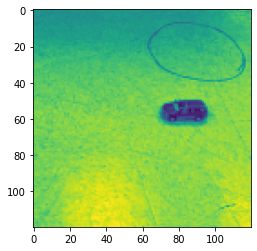

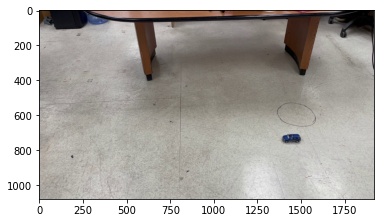

5 165 The action is: [2 2 1] Pan:Nothing-- Tilt:Nothing-- zoom:in--
bbox_state is: [1181, 541, 1598, 958] (500, 500, 3)


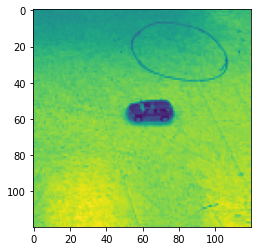

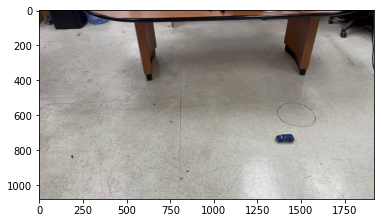

10 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1268, 608, 1509, 849] (241, 241, 3)


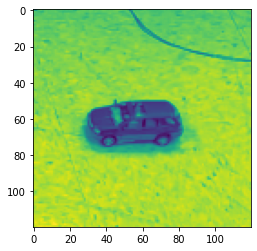

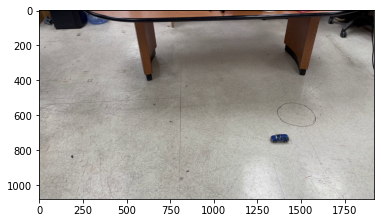

15 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1248, 628, 1448, 828] (200, 200, 3)


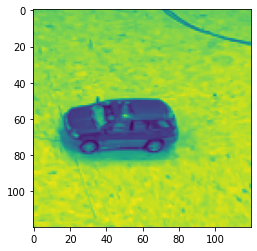

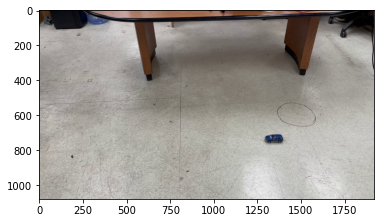

20 165 The action is: [2 2 1] Pan:Nothing-- Tilt:Nothing-- zoom:in--
bbox_state is: [1224, 644, 1391, 811] (200, 200, 3)


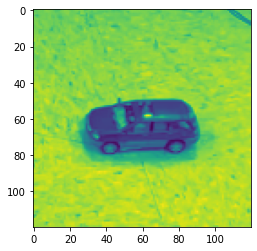

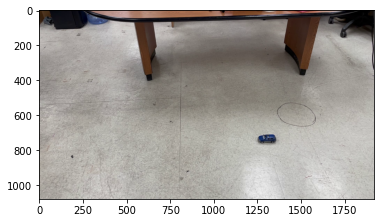

25 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1184, 644, 1351, 811] (167, 167, 3)


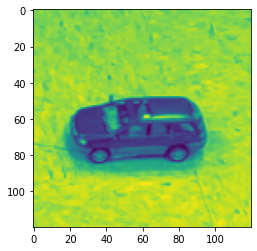

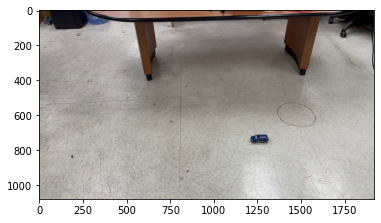

30 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1144, 644, 1311, 811] (167, 167, 3)


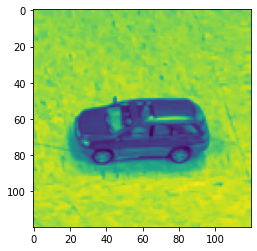

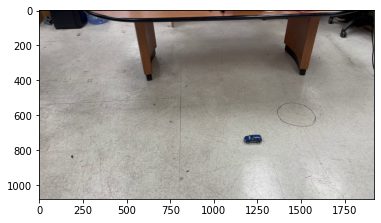

35 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1104, 644, 1271, 811] (167, 167, 3)


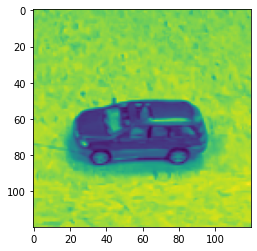

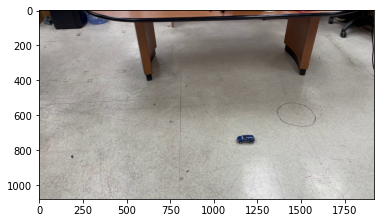

40 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1044, 644, 1211, 811] (167, 167, 3)


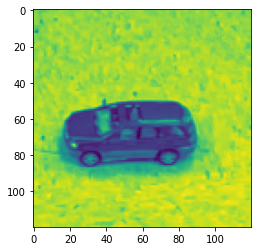

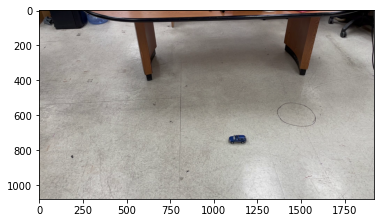

45 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [1024, 644, 1191, 811] (167, 167, 3)


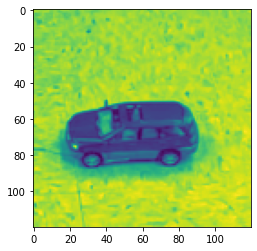

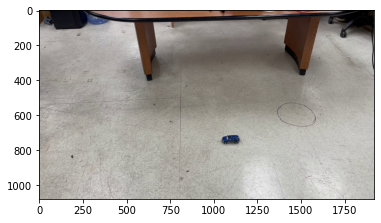

50 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [984, 644, 1151, 811] (167, 167, 3)


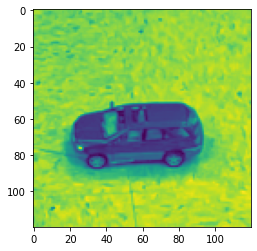

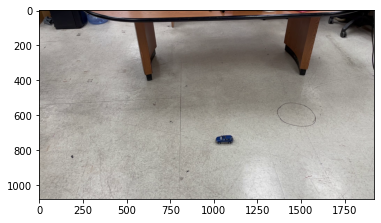

55 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [944, 644, 1111, 811] (167, 167, 3)


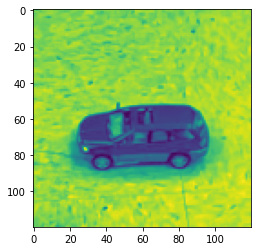

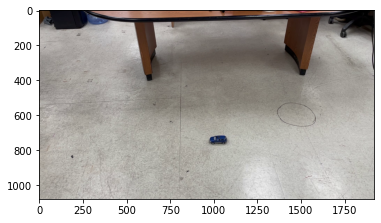

60 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [904, 644, 1071, 811] (167, 167, 3)


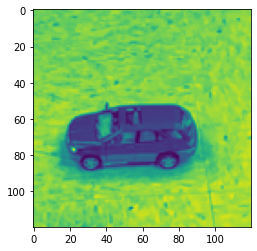

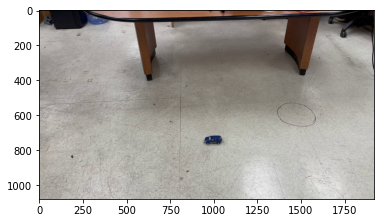

65 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [884, 644, 1051, 811] (167, 167, 3)


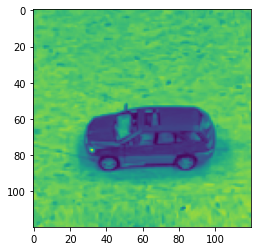

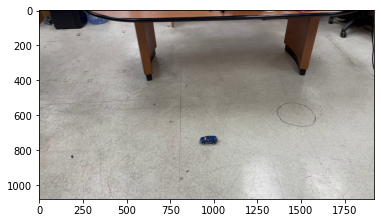

70 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [864, 644, 1031, 811] (167, 167, 3)


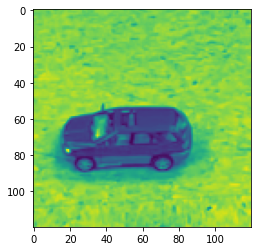

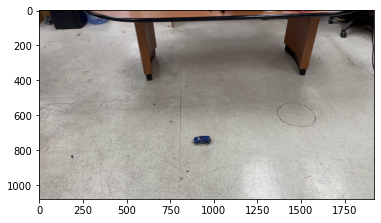

75 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [804, 644, 971, 811] (167, 167, 3)


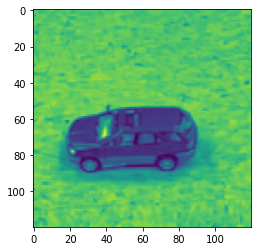

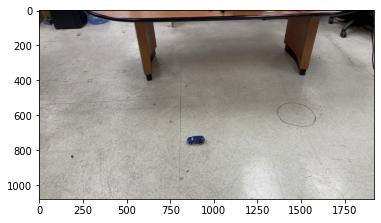

80 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [784, 644, 951, 811] (167, 167, 3)


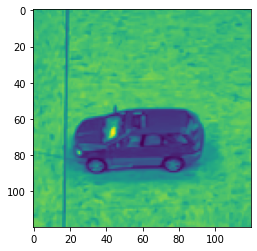

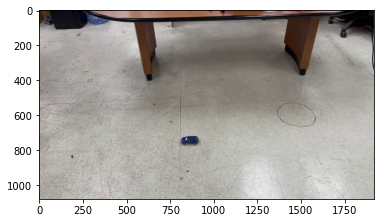

85 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [744, 644, 911, 811] (167, 167, 3)


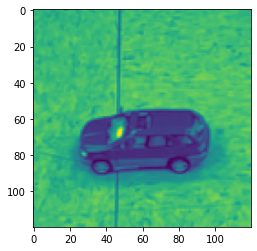

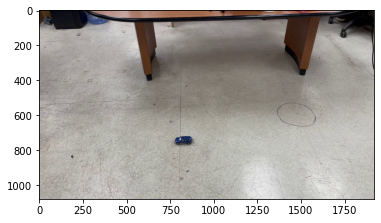

90 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [704, 644, 871, 811] (167, 167, 3)


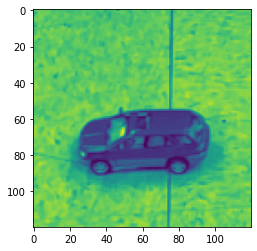

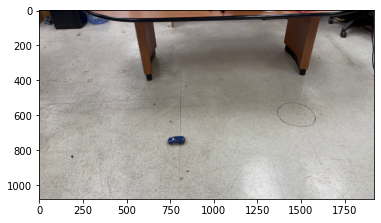

95 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [664, 644, 831, 811] (167, 167, 3)


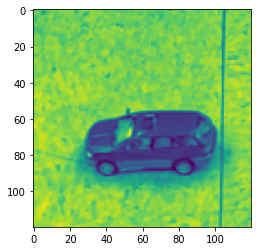

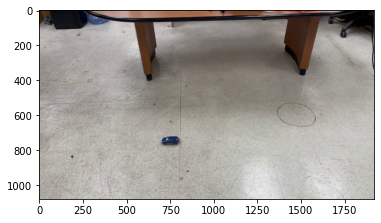

100 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [624, 644, 791, 811] (167, 167, 3)


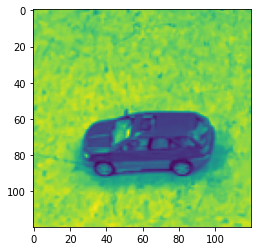

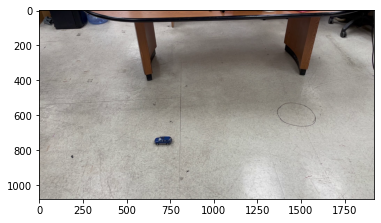

105 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [584, 644, 751, 811] (167, 167, 3)


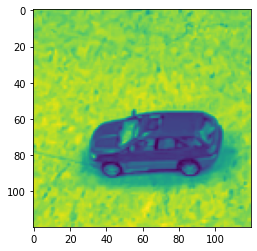

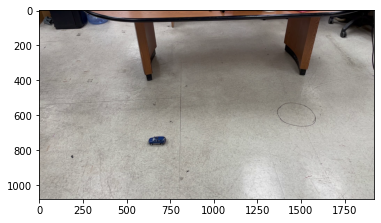

110 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [564, 644, 731, 811] (167, 167, 3)


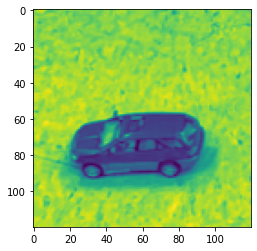

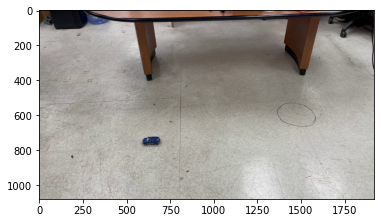

115 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [524, 644, 691, 811] (167, 167, 3)


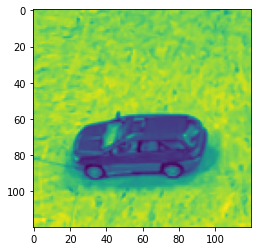

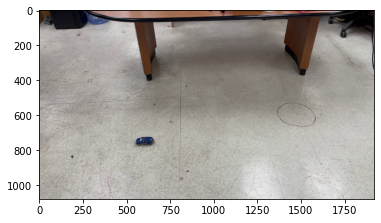

120 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [484, 644, 651, 811] (167, 167, 3)


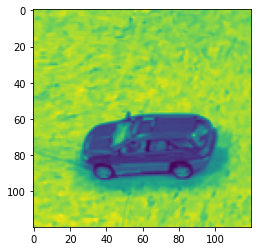

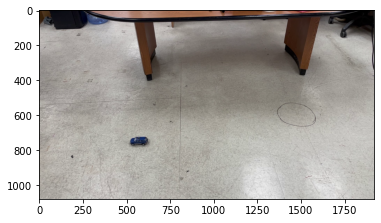

125 165 The action is: [2 2 0] Pan:Nothing-- Tilt:Nothing-- zoom:out--
bbox_state is: [447, 627, 647, 827] (167, 167, 3)


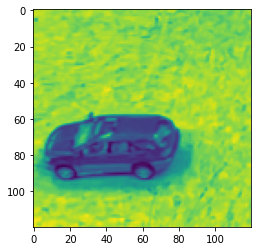

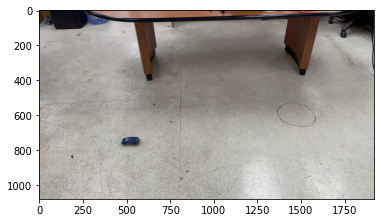

130 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [387, 627, 587, 827] (200, 200, 3)


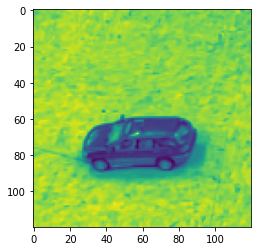

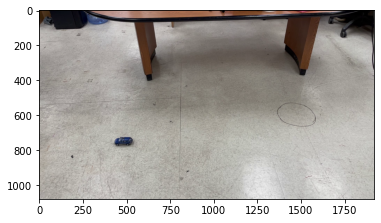

135 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [367, 627, 567, 827] (200, 200, 3)


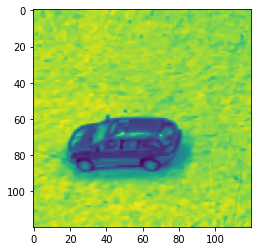

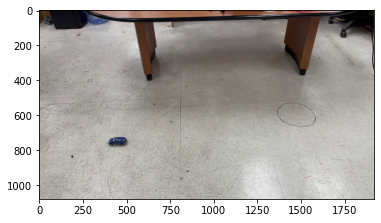

140 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [307, 627, 507, 827] (200, 200, 3)


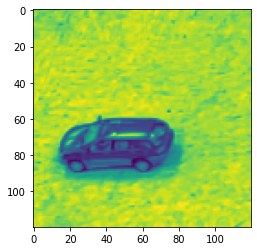

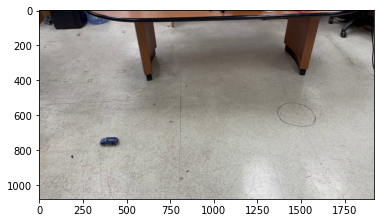

145 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [267, 627, 467, 827] (200, 200, 3)


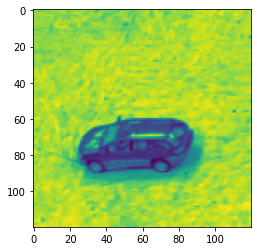

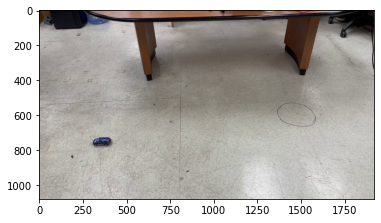

150 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [227, 627, 427, 827] (200, 200, 3)


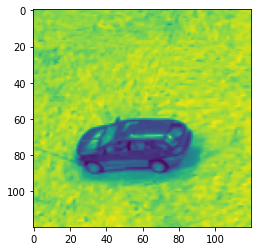

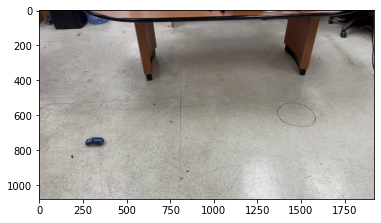

155 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [187, 627, 387, 827] (200, 200, 3)


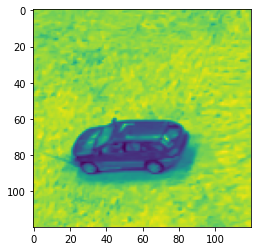

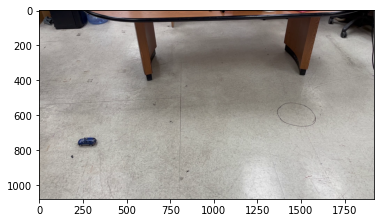

160 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [147, 627, 347, 827] (200, 200, 3)


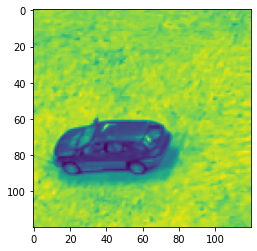

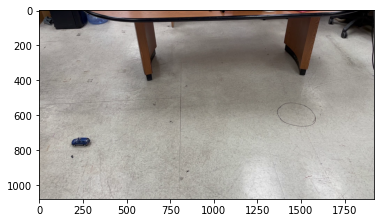

165 165 The action is: [1 2 2] Pan:left-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [107, 627, 307, 827] (200, 200, 3)


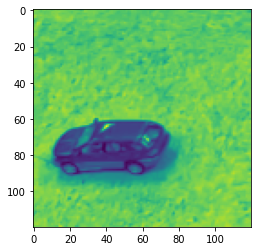

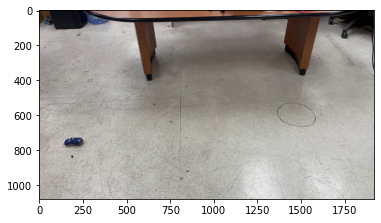

170 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [67, 627, 267, 827] (200, 200, 3)


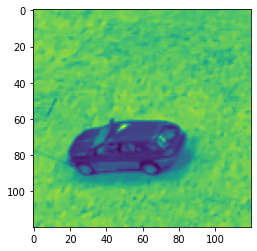

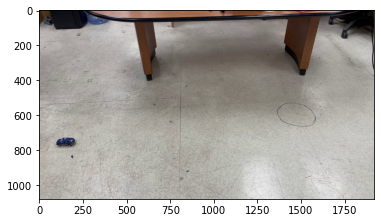

175 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [27, 627, 227, 827] (200, 200, 3)


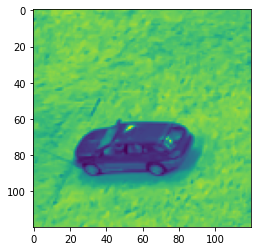

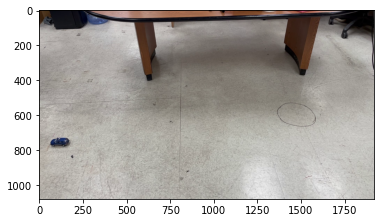

180 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [7, 627, 207, 827] (200, 200, 3)


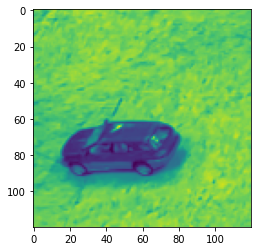

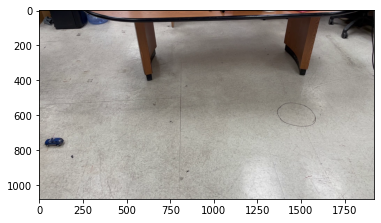

185 165 The action is: [2 2 2] Pan:Nothing-- Tilt:Nothing-- zoom:Nothing--
bbox_state is: [0, 607, 161, 847] (240, 161, 3)


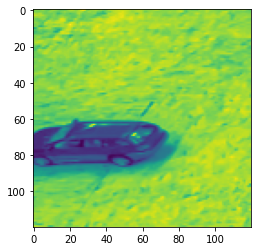

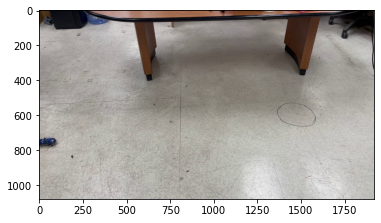

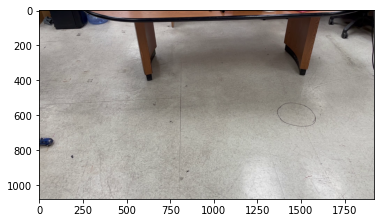

In [19]:
# The starting bounding-box with car in it.
# Model will track this car
Xboxes = [[ 1100, 1600, 500, 1000]]


# The convertion of model actions to bounding-box movements
# These parameters require hand tuning, else actions may-be jerky or may-not work well
delta = 20
zoom_factor = 1.2
zoom_out_factor = 1.2


# Min and max size of the bounding box to maintain
# Zoom simulation require this as a boundary guard.
min_size = 100
max_size = 800

# Action mapping for visualization
action_zoom ={0:'zoom:out--', 1:'zoom:in--', 2:'zoom:Nothing--'}
action_pan ={0:'Pan:right--', 1:'Pan:left--', 2:'Pan:Nothing--'}
action_tilt ={0:'Tilt:up--', 1:'Tilt:down--', 2:'Tilt:Nothing--'}



for xbox in Xboxes:
    
    [x1,x2,y1,y2] = xbox
    bbox_state = [x1,y1,x2,y2]
    IS = VideoSimulator(v_file = path, img_idx = starting_idx)
    
    # Total number of video frames: At the end of video, car goes out of the frame.
    for i in range(188):
        image = IS.get_frame()
        
        #get a patch of image from entire image
        obs, frame = next_state(IS, bbox_state, image)
        
        dim = (120, 120)
        obs = cv2.resize(obs, dim, interpolation = cv2.INTER_AREA)
        
        #print('Obs proper size:', obs.shape)
        obs = convert_rgb_to_gray(obs)
        
        ####save the obs from the PTZ simulated camera if needed
        #if i%1==0:
        #save_next_state_Image(IS, bbox_state, image, i)
        #save_next_obs_Image(bbox_state, image, i)

        obs_input =  obs.reshape(image_size_to_use, image_size_to_use, 1)
        action, _state = model.predict(obs_input, deterministic=True)

        #Update the box_state for next patch based on the action from the model
        updateBox(action)
        
        # See every fifth-frame in this notebook
        if i%5==0:
            print(i, IS.img_idx, 'The action is:', action, action_pan[action[0]], action_tilt[action[1]], action_zoom[action[2]])
            print('bbox_state is:',bbox_state, frame.shape)
            display_observation(obs_input[:,:,0])
            display_observation(image)
        
display_observation(image)